## ch03
- https://github.com/thampiman/interpretable-ai-book/blob/master/Chapter_03/chapter_03.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.9.27</div>
<div style="text-align: right"> Last update: 2023.9.27</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import math
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from pdpbox import pdp, info_plots

from joblib import dump, load

plt.rcParams["font.family"] = "Arial"
sns.set(style='whitegrid')
sns.set_palette("bright")

이전 장에서는 화이트박스와 블랙박스라는 두 가지 유형의 머신러닝 모델을 살펴보고 화이트박스 모델을 해석하는 방법에 대해 집중적으로 살펴봤습니다.  
블랙박스 모델은 예측력이 높지만 이름에서 알 수 있듯이 해석하기가 어렵습니다.  
이 장에서는 블랙박스 모델을 해석하는 데 초점을 맞추고, 모델에 구애받지 않고(model-agnostic) 범위가 넓은(전역적인) 기법에 대해 구체적으로 배우게 됩니다.  
1장에서 model agnostic 해석 기법은 사용되는 특정 모델 유형에 의존하지 않는다는 점을 기억하세요.  
모델의 내부 구조와 무관하기 때문에 모든 모델에 적용할 수 있습니다.  
또한 글로벌 범위의 해석 가능성 기법은 전체 모델을 전체적으로 이해하는 데 도움이 될 수 있습니다.  
또한 트리 앙상블, 특히 랜덤 포레스트에 초점을 맞출 것입니다.  
여기서는 랜덤 포레스트에 초점을 맞추었지만, 이 장에서 배울 model agnostic 기법을 모든 모델에 적용할 수 있습니다.  
다음 장에서는 신경망과 같은 더 복잡한 블랙박스 모델로 관심을 전환할 것입니다.  
4장에서는 LIME, SHAP, 앵커와 같이 범위에 국한된 model agnostic 기법에 대해서도 배우게 됩니다.

### High school student performance predictor

미국의 한 교육구의 교육감이 데이터 과학 문제에 대해 도움을 요청해 왔습니다.  
교육감은 수학, 읽기, 쓰기라는 세 가지 주요 과목 영역에서 학생들의 성적을 파악하여 여러 학교에 필요한 자금 수준을 결정하고 모든 학생 성공법(ESSA)의 일환으로 모든 학생이 성공할 수 있도록 보장하고자 합니다.  
교육감은 특히 수학, 읽기, 쓰기 과목에서 교육구 내 한 고등학생의 성적을 예측하는 데 도움을 받고 싶어합니다.  
이 정보가 주어지면 이 문제를 어떻게 머신 러닝 문제로 공식화할 수 있을까요?  
모델의 목표는 네 가지 불연속 값 중 하나가 될 수 있는 성적을 예측하는 것이므로 이 문제는 분류 문제로 공식화할 수 있습니다.  
데이터 측면에서 교육감은 다양한 학교와 배경을 대표하는 교육구 내 학생 1,000명의 데이터를 수집했습니다.  
각 학생에 대해 다음과 같은 다섯 가지 데이터 포인트가 수집됩니다:   

- Gender
- Ethnicity(민족)
- Parent Level of Education
- Type of Lunch purchased by the student(학생이 구매한 도시락 유형)
- Test Preparation level(시험 준비 수준)

주어진 데이터로 세가지의 분류기를 만들어야 한다.  

![Alt text](image.png)

### Load data and EDA

- Grade A: score >= 80
- Grade B: 60 <= score < 80
- Grade C: 40 <= score < 60
- Grade F: score < 40

In [3]:
df = pd.read_csv('StudentsPerformance.csv')
df.shape

(1000, 8)

In [4]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
def score_to_grade(score):
    if score >= 80:
        return 'A'
    if score >= 60:
        return 'B'
    if score >= 40:
        return 'C'
    return 'F'

In [6]:
df['math grade'] = df['math score'].apply(score_to_grade)
df['reading grade'] = df['reading score'].apply(score_to_grade)
df['writing grade'] = df['writing score'].apply(score_to_grade)

### EDA

In [7]:
df['gender'].value_counts() / len(df) *100

gender
female    51.8
male      48.2
Name: count, dtype: float64

In [8]:
df['race/ethnicity'].value_counts()

race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

In [9]:
df['parental level of education'].value_counts()

parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

In [10]:
def plot_vc_bar_charts(df, col, ax, color='b'):
    df_vc = df[col].value_counts() / len(df) * 100
    df_vc = df_vc.reset_index()
    df_vc = df_vc.rename(columns={'index': col, col: 'pc'})
    
    bar_width = 0.35
    opacity = 0.9
    labels = df_vc['pc'].values
    capitalized_labels = []
    for label in labels:
        words = label.split(' ')
        capitalized_label = ' '.join([w.capitalize() for w in words])
        capitalized_labels.append(capitalized_label)
    sizes = df_vc['count'].values
    index = np.arange(len(sizes))
    
    ax.bar(index, sizes, bar_width,
           alpha=opacity,
           label=labels,
           color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(capitalized_labels)
    ax.grid(True);


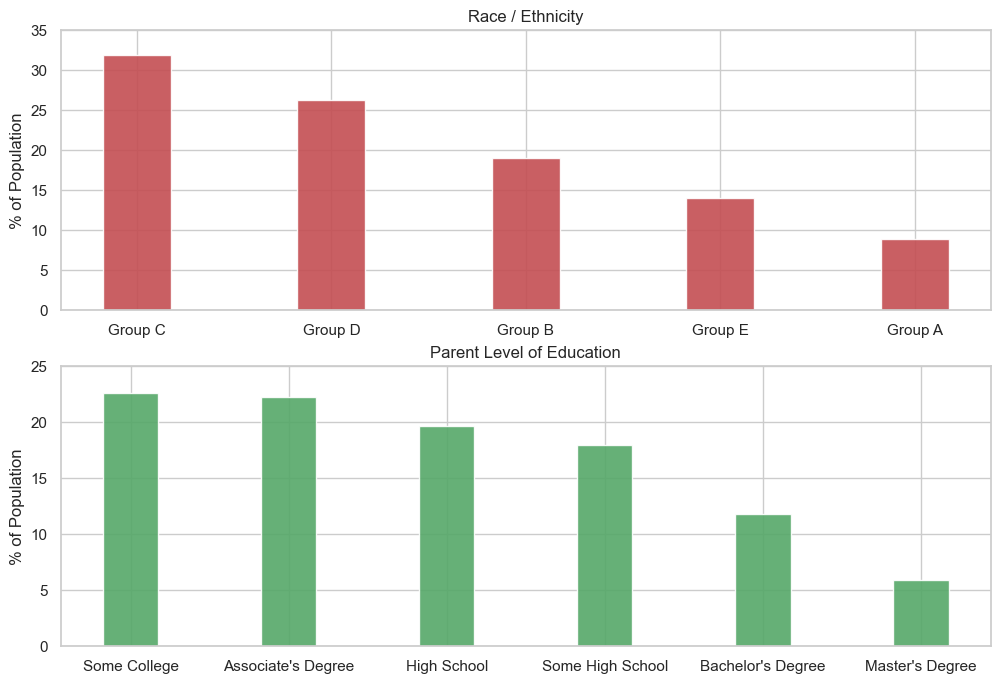

In [11]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_vc_bar_charts(df, 'race/ethnicity', ax=ax[0], color='r')
plot_vc_bar_charts(df, 'parental level of education', ax=ax[1], color='g')
ax[0].set_title('Race / Ethnicity')
ax[1].set_title('Parent Level of Education');
ax[0].set_ylabel('% of Population');
ax[1].set_ylabel('% of Population');
ax[0].set_ylim([0, 35])
ax[1].set_ylim([0, 25]);


- 학생 인구에는 5개의 그룹 또는 민족이 있으며, 그룹 C와 D가 학생 인구의 약 58%를 차지하여 가장 많은 비중을 차지합니다.  
- 여섯 가지 수준의 부모 교육이 이루어집니다. 오름차순으로 고등학교, (인정) 고등학교, 일부 대학, 준학사 학위, 학사 학위, 석사 학위입니다. 부모의 교육 수준이 낮은 학생이 훨씬 더 많은 것으로 보입니다. 학생의 약 82%는 고등학교 또는 대학교 학력 또는 관련 학위를 가진 부모를 둔 학생입니다. 학사 또는 석사 학위를 가진 부모를 둔 학생은 18%에 불과합니다.

In [12]:
df['lunch'].value_counts()

lunch
standard        645
free/reduced    355
Name: count, dtype: int64

In [13]:
df['test preparation course'].value_counts()

test preparation course
none         642
completed    358
Name: count, dtype: int64

In [14]:

def get_stats(df, grade_col):
    df_grade = df.groupby([grade_col]).agg({'lunch': 'count'}).reset_index()
    df_grade = df_grade.rename(columns={'lunch': 'count'})
    df_grade['pc'] = df_grade['count'] / len(df) * 100
    
    df_gender = df.groupby(['gender', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_gender = df_gender.rename(columns={'lunch': 'count'})
    df_gender['pc'] = df_gender['count'] / len(df) * 100
    
    df_race = df.groupby(['race/ethnicity', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_race = df_race.rename(columns={'lunch': 'count'})
    df_race['pc'] = df_race['count'] / len(df) * 100
    
    df_parent = df.groupby(['parental level of education', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_parent = df_parent.rename(columns={'lunch': 'count'})
    df_parent['pc'] = df_parent['count'] / len(df) * 100
    
    df_lunch = df.groupby(['lunch', grade_col]).agg({'gender': 'count'}).reset_index()
    df_lunch = df_lunch.rename(columns={'gender': 'count'})
    df_lunch['pc'] = df_lunch['count'] / len(df) * 100
    
    df_test_prep = df.groupby(['test preparation course', grade_col]).agg({'gender': 'count'}).reset_index()
    df_test_prep = df_test_prep.rename(columns={'gender': 'count'})
    df_test_prep['pc'] = df_lunch['count'] / len(df) * 100
    
    return df_grade, df_gender, df_race, df_parent, df_lunch, df_test_prep

In [15]:
df_grade_math, df_gender_math, df_race_math, df_parent_math, df_lunch_math, df_test_prep_math = get_stats(df, 'math grade')
df_grade_reading, df_gender_reading, df_race_reading, df_parent_reading, df_lunch_reading, df_test_prep_reading = get_stats(df, 'reading grade')
df_grade_writing, df_gender_writing, df_race_writing, df_parent_writing, df_lunch_writing, df_test_prep_writing = get_stats(df, 'writing grade')

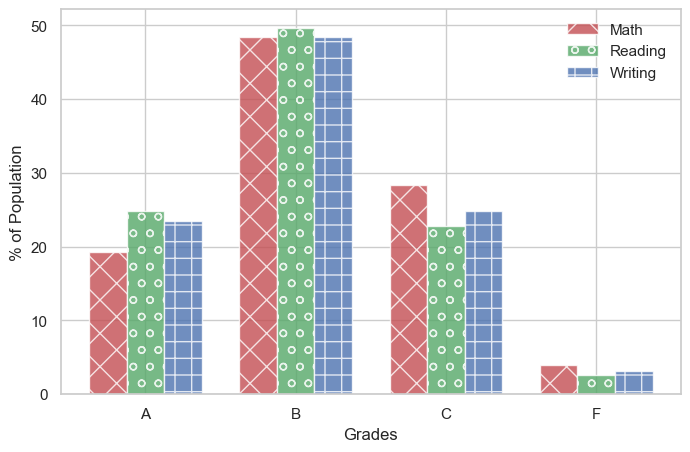

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.25

opacity = 0.8
error_config = {'ecolor': '0.3'}

ax.bar(index, df_grade_math['pc'], bar_width,
       alpha=opacity, color='r',
       label='Math',
       hatch='x')
ax.bar(index + bar_width, df_grade_reading['pc'], bar_width,
       alpha=opacity, color='g',
       label='Reading',
       hatch='o')
ax.bar(index + bar_width * 2, df_grade_writing['pc'], bar_width,
       alpha=opacity, color='b',
       label='Writing',
       hatch='+')

ax.set_xlabel('Grades')
ax.set_ylabel('% of Population')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(grades)
ax.legend()

- 이제 나머지 두 가지 기능인 구매 점심 유형과 시험 준비 수준에 대해 알아보겠습니다. 
- 대다수(약 65%)가 표준 도시락을 구매하고 나머지는 무료/할인 도시락을 구매했습니다.  
- 시험 준비 수준에서는 36%의 학생만이 시험 준비를 완료했고, 나머지는 완료하지 못했거나 알 수 없었으며, 
- 이제 세 가지 과목 영역에서 A, B, C, F 등급을 받은 학생의 비율을 살펴봅시다. 이는 그림 3.3에 나와 있습니다. 대부분의 학생(48~50%)이 B등급을, 극소수의 학생(3~4%)이 F등급을 받은 것을 볼 수 있습니다. 약 18~25%의 학생이 A등급을, 22~28%의 학생이 세 과목 영역 모두에서 C등급을 받은 것을 볼 수 있습니다. 모델을 학습시키기 전에 데이터가 상당히 불균형하다는 점에 유의하는 것이 중요합니다. 이것이 왜 중요하며, 불균형한 데이터를 어떻게 처리해야 할까요? 분류 유형의 문제에서 특정 클래스에 대해 불균형한 수의 예시 또는 데이터 포인트가 존재할 때 데이터가 불균형하다고 말합니다. 대부분의 머신러닝 알고리즘은 각 클래스에 대한 샘플의 비율이 거의 동일할 때 가장 잘 작동하기 때문에 이 점에 유의하는 것이 중요합니다. 대부분의 알고리즘은 오류를 최소화하거나 정확도를 극대화하도록 설계되어 있으며, 이러한 알고리즘은 자연스럽게 다수 클래스에 편향되는 경향이 있습니다. 이러한 일반적인 접근 방식을 포함하여 몇 가지 방법으로 불균형한 클래스를 처리할 수 있습니다:

- 모델을 테스트하고 평가할 때 올바른 성능 지표를 사용합니다.
- 대다수 클래스가 언더샘플링되거나 또는 소수 클래스가 오버샘플링되도록 훈련 데이터를 샘플링합니다.

데이터를 좀 더 자세히 분석해 보겠습니다.   
다음에 나오는 인사이트는 3.4절에서 모델이 학습한 내용을 해석하고 검증해야 할 때 유용할 것입니다.  
부모의 교육 수준이 가장 낮은 학생과 가장 높은 학생의 성적은 일반적으로 어떻게 될까요?  
부모의 교육 수준이 가장 낮은 학생(즉, 고등학교 졸업)과 가장 높은 학생(즉, 석사 학위)의 성적 분포를 비교해 보겠습니다.   
그림 3.4는 세 가지 과목 영역 모두에서 이러한 비교를 보여줍니다.

![Alt text](image-1.png)

- 부모가 고등학교 학력을 가진 학생에 초점을 맞춰 보겠습니다.   
세 가지 과목 영역 모두에서 일반적으로 전체 인구보다 A 등급을 받는 학생 수가 적고 F 등급을 받는 학생 수가 많은 것으로 보입니다.  
예를 들어 수학 과목의 경우, 부모가 고등학교 교육을 받은 학생의 10%만이 A 등급을 받은 반면, 전체 인구에서는(그림 3.3에서 보았듯이) 약 20%의 학생이 A 등급을 받았습니다.   
- 이제 부모가 석사 학위를 가진 학생에 초점을 맞춰 보겠습니다.   
일반적으로 전체 인구와 비교했을 때 A 등급을 받은 학생은 더 많고 F 등급을 받은 학생은 0명인 것처럼 보입니다.   
예를 들어 수학 과목의 경우, 부모가 석사 학위를 가진 학생의 약 30%가 A 등급을 받습니다.   
- 이제 그림 3.4의 두 막대를 비교하면 세 과목 모두에서 부모의 교육 수준이 높을수록 더 많은 학생이 더 높은 등급(A 또는 B)을 받는 것을 볼 수 있습니다.   

- 인종은 어떻습니까?   
가장 대표성이 높은 그룹에 속한 학생과 가장 대표성이 낮은 그룹에 속한 학생의 성적은 어떻게 비교될까요?   
그림 3.2에서 가장 대표성이 높은 그룹은 C이고 가장 대표성이 낮은 그룹은 A라는 것을 알 수 있습니다.  
그림 3.5는 C 그룹에 속한 학생과 A 그룹에 속한 학생의 성적 분포를 비교한 것으로, 일반적으로 C 그룹에 속한 학생이 A 그룹에 속한 학생보다 더 높은 성적(A 또는 B)을 받는 학생 비율이 더 많고 낮은 성적(C 또는 F)을 받는 학생 비율이 더 적은 것처럼 보입니다. 앞서 언급했듯이 이 섹션의 인사이트는 3.4절에서 모델이 학습한 내용을 해석하고 검증할 때 유용하게 사용할 수 있습니다.

![Alt text](image-2.png)

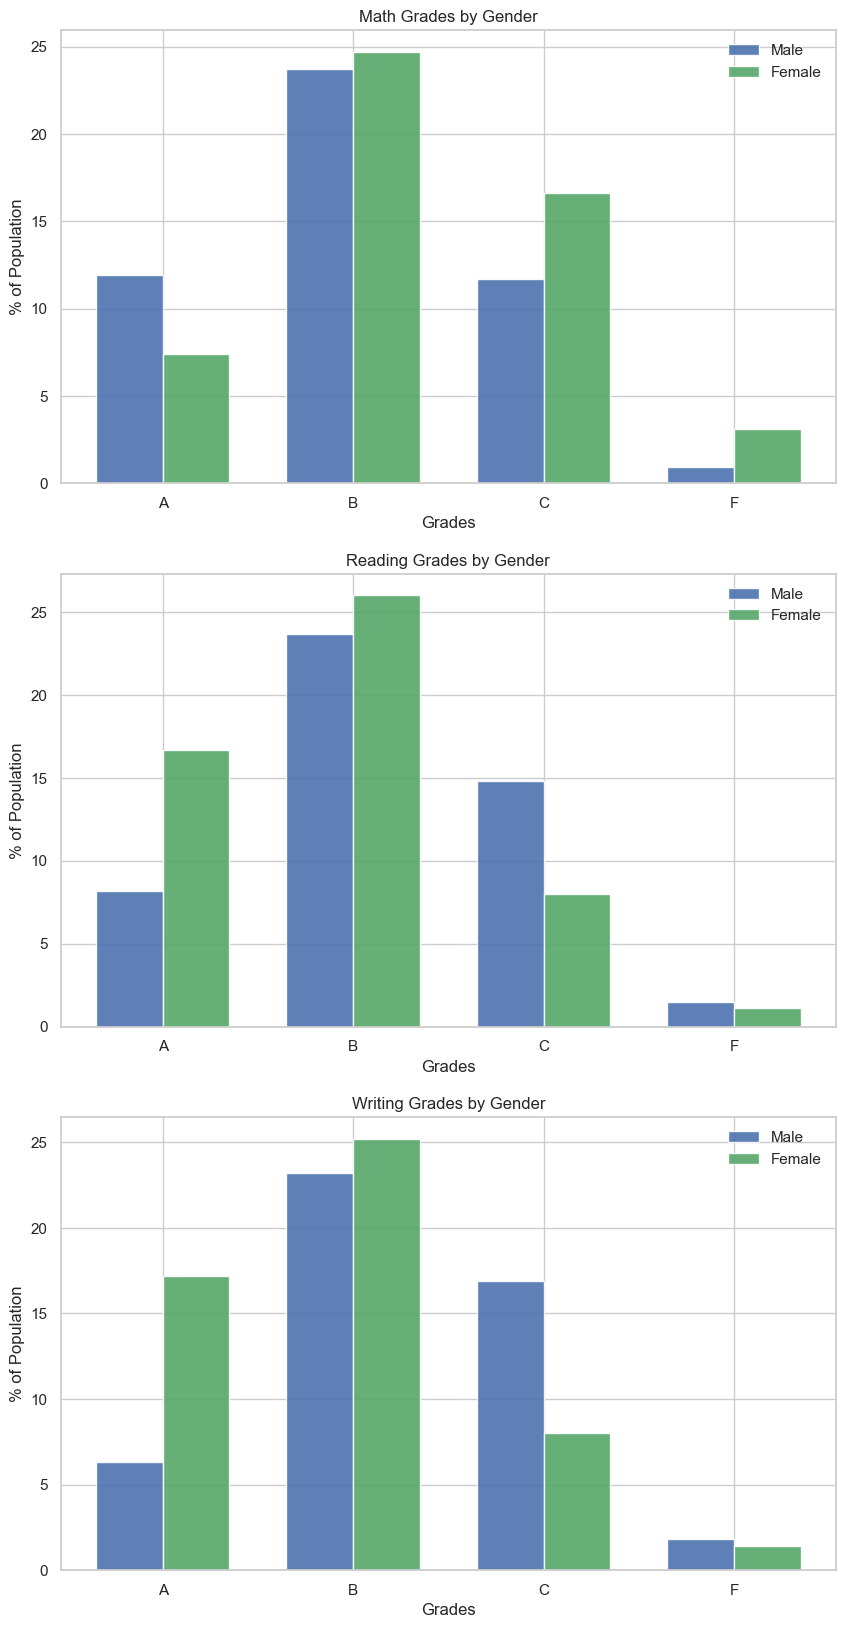

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.9
error_config = {'ecolor': '0.3'}

ax[0].bar(index, df_gender_math[df_gender_math['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[0].bar(index + bar_width, df_gender_math[df_gender_math['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[0].set_xlabel('Grades')
ax[0].set_ylabel('% of Population')
ax[0].set_title('Math Grades by Gender')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
ax[0].grid(True);

ax[1].bar(index, df_gender_reading[df_gender_reading['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[1].bar(index + bar_width, df_gender_reading[df_gender_reading['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[1].set_xlabel('Grades')
ax[1].set_ylabel('% of Population')
ax[1].set_title('Reading Grades by Gender')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
ax[1].grid(True);

ax[2].bar(index, df_gender_writing[df_gender_writing['gender'] == 'male']['pc'], bar_width,
                alpha=opacity, color='b',
                label='Male')
ax[2].bar(index + bar_width, df_gender_writing[df_gender_writing['gender'] == 'female']['pc'], bar_width,
                alpha=opacity, color='g',
                label='Female')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population')
ax[2].set_title('Writing Grades by Gender')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
ax[2].grid(True);


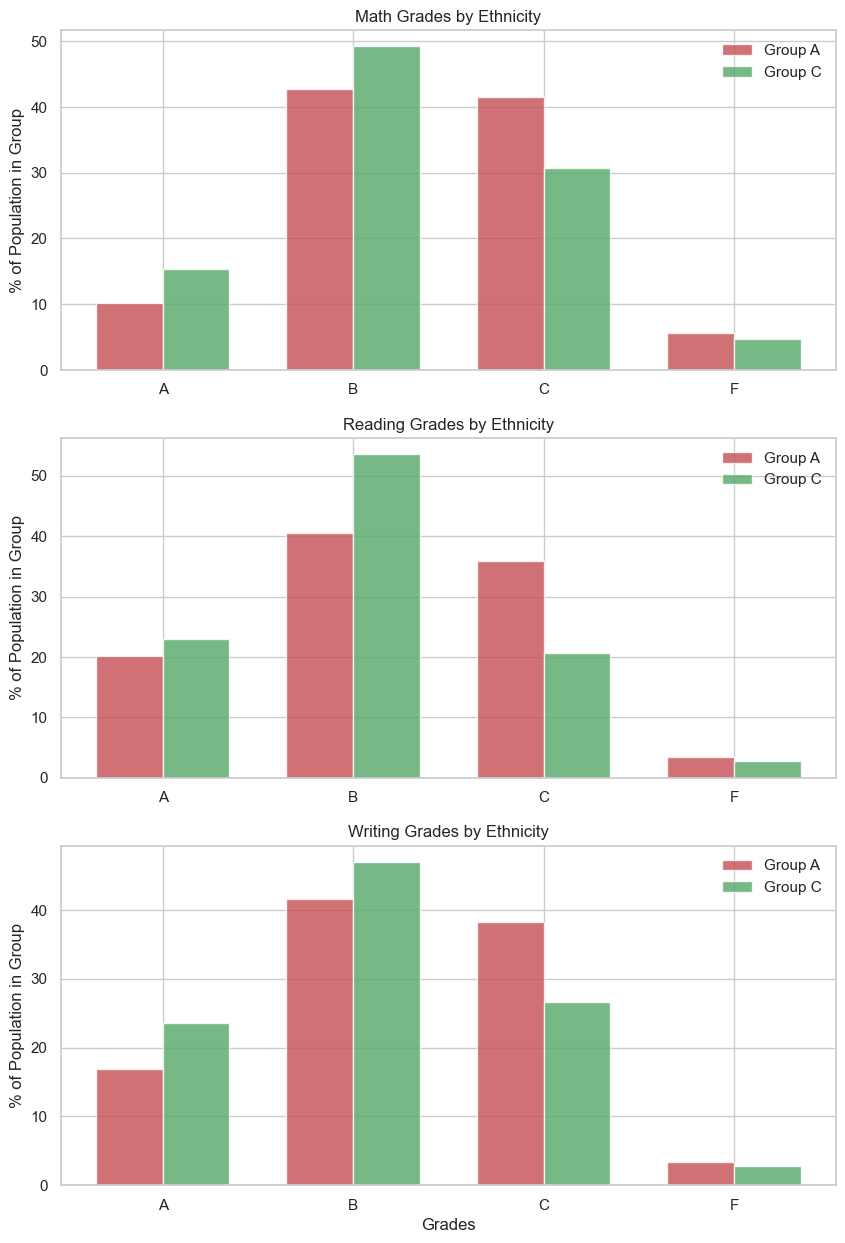

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

math_a_sum = df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'].sum()
math_c_sum = df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'].sum()
ax[0].bar(index, df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'] / math_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[0].bar(index + bar_width, df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'] / math_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[0].set_xlabel('')
ax[0].set_ylabel('% of Population in Group')
ax[0].set_title('Math Grades by Ethnicity')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
#     ax[0].set_ylim([0, 16])
ax[0].grid(True);

read_a_sum = df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'].sum()
read_c_sum = df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'].sum()
ax[1].bar(index, df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'] / read_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[1].bar(index + bar_width, df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'] / read_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[1].set_xlabel('')
ax[1].set_ylabel('% of Population in Group')
ax[1].set_title('Reading Grades by Ethnicity')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
#     ax[1].set_ylim([0, 18])
ax[1].grid(True);

write_a_sum = df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'].sum()
write_c_sum = df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'].sum()
ax[2].bar(index, df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'] / write_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='Group A')
ax[2].bar(index + bar_width, df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'] / write_c_sum * 100, bar_width,
                alpha=opacity, color='g',
                label='Group C')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population in Group')
ax[2].set_title('Writing Grades by Ethnicity')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
#     ax[2].set_ylim([0, 16])
ax[2].grid(True);

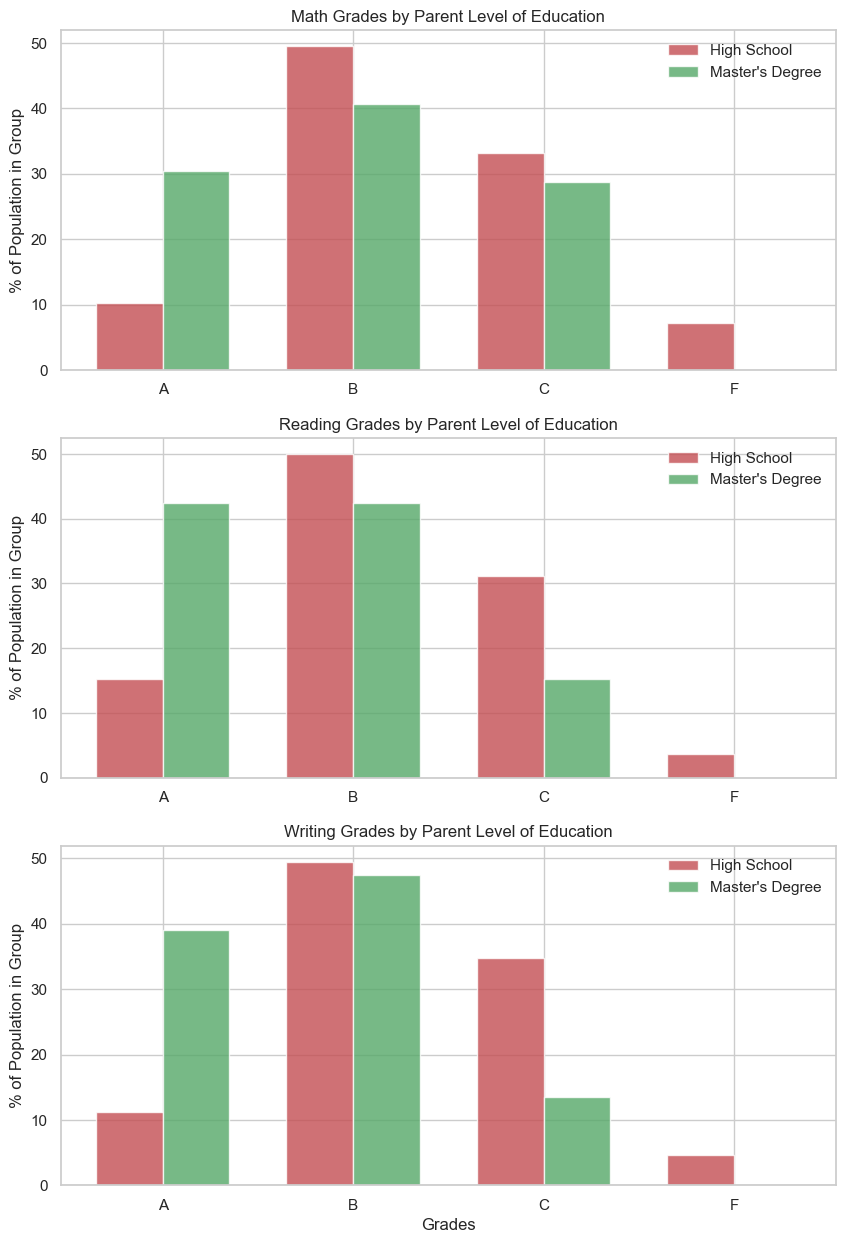

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grades = ['A', 'B', 'C', 'F']
index = np.arange(len(grades))
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

math_a_sum = df_parent_math[df_parent_math['parental level of education'] == 'high school']['pc'].sum()
math_c_sum = df_parent_math[df_parent_math['parental level of education'] == 'master\'s degree']['pc'].sum()
math_ma_pc = np.array(df_parent_math[df_parent_math['parental level of education'] == 'master\'s degree']['pc'].values) / math_c_sum * 100
math_ma_pc = np.append(math_ma_pc, 0) # for grade f
ax[0].bar(index, df_parent_math[df_parent_math['parental level of education'] == 'high school']['pc'] / math_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[0].bar(index + bar_width, 
          math_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[0].set_xlabel('')
ax[0].set_ylabel('% of Population in Group')
ax[0].set_title('Math Grades by Parent Level of Education')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(grades)
ax[0].legend()
#     ax[0].set_ylim([0, 16])
ax[0].grid(True);

read_a_sum = df_parent_reading[df_parent_reading['parental level of education'] == 'high school']['pc'].sum()
read_c_sum = df_parent_reading[df_parent_reading['parental level of education'] == 'master\'s degree']['pc'].sum()
read_ma_pc = np.array(df_parent_reading[df_parent_reading['parental level of education'] == 'master\'s degree']['pc'].values) / read_c_sum * 100
read_ma_pc = np.append(read_ma_pc, 0) # for grade f
ax[1].bar(index, df_parent_reading[df_parent_reading['parental level of education'] == 'high school']['pc'] / read_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[1].bar(index + bar_width, read_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[1].set_xlabel('')
ax[1].set_ylabel('% of Population in Group')
ax[1].set_title('Reading Grades by Parent Level of Education')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(grades)
ax[1].legend()
#     ax[1].set_ylim([0, 18])
ax[1].grid(True);

write_a_sum = df_parent_writing[df_parent_writing['parental level of education'] == 'high school']['pc'].sum()
write_c_sum = df_parent_writing[df_parent_writing['parental level of education'] == 'master\'s degree']['pc'].sum()
write_ma_pc = np.array(df_parent_writing[df_parent_writing['parental level of education'] == 'master\'s degree']['pc'].values) / write_c_sum * 100
write_ma_pc = np.append(write_ma_pc, 0) # for grade f
ax[2].bar(index, df_parent_writing[df_parent_writing['parental level of education'] == 'high school']['pc'] / write_a_sum * 100, bar_width,
                alpha=opacity, color='r',
                label='High School')
ax[2].bar(index + bar_width, write_ma_pc, bar_width,
                alpha=opacity, color='g',
                label='Master\'s Degree')

ax[2].set_xlabel('Grades')
ax[2].set_ylabel('% of Population in Group')
ax[2].set_title('Writing Grades by Parent Level of Education')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(grades)
ax[2].legend()
#     ax[2].set_ylim([0, 16])
ax[2].grid(True);

### Data Preparation

레이블 인코딩 준비

In [20]:
ple = ['high school', 'some high school', 'some college', "bachelor's degree", "associate's degree", "master's degree"]
ple_map = {}
for idx, p in enumerate(ple):
    ple_map[p] = idx

In [21]:
ple_map

{'high school': 0,
 'some high school': 1,
 'some college': 2,
 "bachelor's degree": 3,
 "associate's degree": 4,
 "master's degree": 5}

In [22]:
# First, encode the input features
gender_le = LabelEncoder()
race_le = LabelEncoder()
parent_le = LabelEncoder()
lunch_le = LabelEncoder()
test_prep_le = LabelEncoder()

gender_le.fit(df['gender'])
race_le.fit(df['race/ethnicity'])
parent_le.fit(df['parental level of education'])
lunch_le.fit(df['lunch'])
test_prep_le.fit(df['test preparation course'])

df['gender_le'] = gender_le.transform(df['gender'])
df['race_le'] = race_le.transform(df['race/ethnicity'])
df['parent_le'] = df['parental level of education'].apply(lambda x: ple_map[x])
df['lunch_le'] = lunch_le.transform(df['lunch'])
df['test_prep_le'] = test_prep_le.transform(df['test preparation course']);

In [23]:
# 타겟 변수 인코딩
math_grade_le = LabelEncoder()
reading_grade_le = LabelEncoder()
writing_grade_le = LabelEncoder()

math_grade_le.fit(df['math grade'])
reading_grade_le.fit(df['reading grade'])
writing_grade_le.fit(df['writing grade'])

df['math_grade_le'] = math_grade_le.transform(df['math grade'])
df['reading_grade_le'] = reading_grade_le.transform(df['reading grade'])
df['writing_grade_le'] = writing_grade_le.transform(df['writing grade'])

In [24]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math grade,reading grade,writing grade,gender_le,race_le,parent_le,lunch_le,test_prep_le,math_grade_le,reading_grade_le,writing_grade_le
0,female,group B,bachelor's degree,standard,none,72,72,74,B,B,B,0,1,3,1,1,1,1,1
1,female,group C,some college,standard,completed,69,90,88,B,A,A,0,2,2,1,0,1,0,0
2,female,group B,master's degree,standard,none,90,95,93,A,A,A,0,1,5,1,1,0,0,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,C,C,C,1,0,4,0,1,2,2,2
4,male,group C,some college,standard,none,76,78,75,B,B,B,1,2,2,1,1,1,1,1


In [25]:
df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['math_grade_le'], 
                                         shuffle=True, random_state=42)
df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [26]:
# 인코딩 벡터만 추출
feature_cols = ['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']

X_train_val = df_train_val[feature_cols]
X_test = df_test[feature_cols]
y_math_train_val = df_train_val['math_grade_le']
y_reading_train_val = df_train_val['reading_grade_le']
y_writing_train_val = df_train_val['writing_grade_le']
y_math_test = df_test['math_grade_le']
y_reading_test = df_test['reading_grade_le']
y_writing_test = df_test['writing_grade_le']

### Train models

In [27]:
def create_random_forest_model(n_estimators, 
                               max_depth=10,
                               criterion='gini',
                               random_state=42,
                               n_jobs=4):
    return RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  criterion=criterion,
                                  random_state=random_state,
                                  n_jobs=n_jobs)

### Math grade model

In [28]:
math_model = create_random_forest_model(50)
math_model.fit(X_train_val, y_math_train_val)

y_math_model_test = math_model.predict(X_test)
y_math_model_proba_test = math_model.predict_proba(X_test)

In [29]:
y_math_baseline = [1 for _ in range(len(y_math_model_proba_test))]
y_math_baseline

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [30]:
acc = math_model.score(X_test, y_math_test)
print(acc)

0.405


In [31]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_math_test, y_math_model_test, average="weighted")
p_baseline = precision_score(y_math_test, y_math_baseline, average="weighted")
r_baseline = recall_score(y_math_test, y_math_baseline, average="weighted")
recall = recall_score(y_math_test, y_math_model_test, average="weighted")
f1 = f1_score(y_math_test, y_math_model_test, average="weighted")
f1_baseline = f1_score(y_math_test, y_math_baseline, average="weighted")
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.39720034658708003
0.23522500000000002
0.405
0.485
0.3843387141492869
0.3168013468013468


In [32]:
dump(math_model, 'math_model.joblib')

['math_model.joblib']

### Reading Grade model

In [33]:
reading_model = create_random_forest_model(25)
reading_model.fit(X_train_val, y_reading_train_val)

y_reading_model_test = reading_model.predict(X_test)
y_reading_model_proba_test = reading_model.predict_proba(X_test)

In [34]:
y_reading_baseline = [1 for _ in range(len(y_reading_model_test))]


In [35]:
acc = reading_model.score(X_test, y_reading_test)
print(acc)


0.44


In [36]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_reading_test, y_reading_model_test, average="weighted")
p_baseline = precision_score(y_reading_test, y_reading_baseline, average="weighted")
r_baseline = recall_score(y_reading_test, y_reading_baseline, average="weighted")
recall = recall_score(y_reading_test, y_reading_model_test, average="weighted")
f1 = f1_score(y_reading_test, y_reading_model_test, average="weighted")
f1_baseline = f1_score(y_reading_test, y_reading_baseline, average="weighted")
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.39020697568685186
0.225625
0.44
0.475
0.3877311492164433
0.30593220338983046


In [37]:
dump(reading_model, 'reading_model.joblib')

['reading_model.joblib']

### Writing grade model

In [38]:
writing_model = create_random_forest_model(40)
writing_model.fit(X_train_val, y_writing_train_val)

y_writing_model_test = writing_model.predict(X_test)
y_writing_model_proba_test = writing_model.predict_proba(X_test)

In [39]:
y_writing_baseline = [1 for _ in range(len(y_writing_model_test))]

In [40]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_writing_test, y_writing_model_test, average="weighted")
p_baseline = precision_score(y_writing_test, y_writing_baseline, average="weighted")
r_baseline = recall_score(y_writing_test, y_writing_baseline, average="weighted")
recall = recall_score(y_writing_test, y_writing_model_test, average="weighted")
f1 = f1_score(y_writing_test, y_writing_model_test, average="weighted")
f1_baseline = f1_score(y_writing_test, y_writing_baseline, average="weighted")
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.4804376529220084
0.172225
0.46
0.415
0.4203519736842105
0.2434275618374558


In [41]:
dump(writing_model, 'writing_model.joblib')

['writing_model.joblib']

![Alt text](image-3.png)

### Model interpretation

feature importance

In [42]:
math_model = load('math_model.joblib')
reading_model = load('reading_model.joblib')
writing_model = load('writing_model.joblib')

feature_names = ['Gender', 'Ethnicity', 'Parent Level of Education', 
                 'Lunch', 'Test Preparation']
math_fi = math_model.feature_importances_ * 100
reading_fi = reading_model.feature_importances_ * 100
writing_fi = writing_model.feature_importances_ * 100

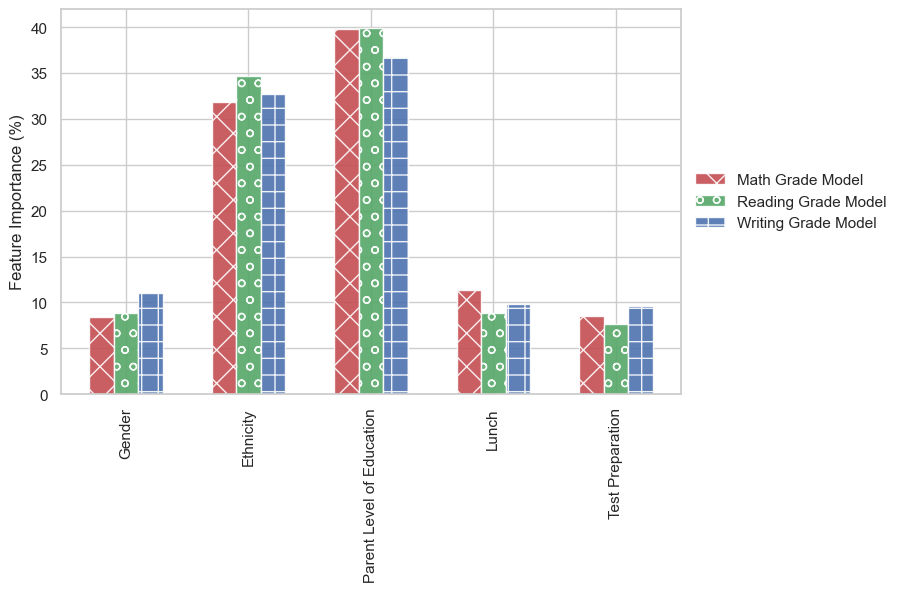

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
index = np.arange(len(feature_names))
bar_width = 0.2
opacity = 0.9
error_config = {'ecolor': '0.3'}
ax.bar(index, math_fi, bar_width,
       alpha=opacity, color='r',
       label='Math Grade Model',
       hatch='x')
ax.bar(index + bar_width, reading_fi, bar_width,
       alpha=opacity, color='g',
       label='Reading Grade Model',
       hatch='o')
ax.bar(index + bar_width * 2, writing_fi, bar_width,
       alpha=opacity, color='b',
       label='Writing Grade Model',
       hatch='+')   
ax.set_xlabel('')
ax.set_ylabel('Feature Importance (%)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(feature_names)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

- 결과를 보면 가장 중요한 피처는 parent level of education, ethnicity이다.   
- 이는 유용한 정보이지만, 교육 수준에 따라 성적이 어떻게 영향을 받는지, 인종과 교육이 서로 어떻게 상호작용하는지에 대해서는 알려주지 않습니다.

또한 트리 앙상블의 특징 중요도를 쉽게 계산하고 시각화할 수 있지만, 4장에서 더 자세히 설명하겠지만 신경망과 더 복잡한 블랙박스 모델을 살펴보면 이 작업이 훨씬 더 어려워집니다. 따라서 블랙박스 모델의 유형에 구애받지 않는 해석 가능성 기법을 살펴볼 필요가 있습니다. 이러한 모델에 구애받지 않는 방법은 다음 섹션에서 소개합니다.

## Model-agnostic methods: Global interpretability

트리 앙상블과 같은 블랙박스 모델의 경우 피처의 전역 상대 중요도를 계산할 수 있지만  
신경망과 같은 다른 블랙박스 모델에는 이 계산을 확장할 수 없습니다.  

블랙박스 모델을 더 잘 해석하기 위해 이제 모든 유형의 모델에 적용할 수 있는 모델에 구애받지 않는 방법을 탐구할 것입니다.  
또한 이 장에서는 글로벌 범위의 해석 가능성 기법에 대해 집중적으로 살펴볼 것입니다.  
글로벌 해석 가능성 기법은 모델 전체, 즉 대상 변수에 대한 피처의 글로벌 효과를 더 잘 이해하는 것을 목표로 합니다.  

전역적으로 해석 가능한 모델에 구애받지 않는 방법은 부분 의존도 플롯(PDP)입니다.  
다음 섹션에서는 GAM 2장에서 학습한 PDP를 랜덤 포레스트와 같은 블랙박스 모델로 확장하는 방법을 살펴보겠습니다.  
PDP의 정의를 공식화하고 두 피처 간의 상호 작용을 시각화하여 모델이 피처 간의 의존성을 포착했는지 검증하기 위해 PDP를 확장하는 방법도 살펴볼 것입니다.  
모델에 구애받지 않는 해석 가능성 기법은 범위가 국지적일 수도 있습니다.  
이러한 기법을 사용하여 주어진 로컬 인스턴스 또는 예측에 대한 모델을 해석할 수 있습니다.  
LIME, SHAP 및 앵커와 같은 기법은 모델에 구애받지 않고 범위가 로컬이며, 4장에서 이에 대해 자세히 알아볼 것입니다.

### Partial dependence plots

pdp의 개본 개념은 모델 예측에 대한 다양한 특징값의 한계(maginal) 또는 평균 효과를 보여주기 위한 것으로, f를 모델이 학습한 함수라고 합니다.  
고등학생 예측 문제의 경우, 수학, 읽기, 쓰기 과목 영역에 대해 각각 훈련된 랜덤 포레스트 모델이 학습한 함수를 fmath, freading, fwriting이라고 하고, 각 과목에 대해 입력된 특징이 주어졌을 때 특정 성적을 받을 확률을 반환하는 함수를 f라고 해봅시다. 이제 이해를 돕기 위해 수학 랜덤 포레스트 모델에 집중해 보겠습니다. 지금 배우게 될 이론을 다른 과목 영역으로 쉽게 확장할 수 있습니다.  

수학 랜덤 포레스트 모델에서 부모의 교육 수준이 특정 성적을 예측하는 데 어떤 영향을 미치는지 이해하고자 한다고 가정해 보겠습니다. 이를 위해서는 다음을 수행해야 합니다:   
- 나머지 피처에는 기존에 사용한 데이터와 동일한 값을 사용  
- 부모교육수즌 피처에는 인공 데이터를 생성
- 모델을 구동하여 예측 결과를 얻음
- 예측 평균을 구해 전체 평균 효과를 결정

좀 더 포멀하게, 특징 S의 부분 종속성을 플롯하려면 집합 C로 표현된 나머지 특징을 한계화하고, 특징 S를 관심 값으로 설정한 다음, 집합 C에 있는 모든 특징의 값을 알고 있다고 가정하여 특징 S에 대한 수학 모델의 평균 효과를 살펴봅니다. 구체적인 예를 살펴보겠습니다. 부모의 교육 수준이 학생의 수학 성적에 미치는 한계 효과를 이해하는 데 관심이 있다고 가정해 보겠습니다. 이 경우 특징값 S는 부모 교육 수준이고 나머지 특징값은 C로 표시됩니다. 예를 들어 고등학교 교육 수준의 효과를 이해하기 위해 특징값 S를 고등학교 교육에 해당하는 값(관심 값)으로 설정하고 나머지 특징값을 알고 있다고 가정하여 수학 모델 출력의 평균을 구합니다. 수학적으로 이는 다음 방정식으로 표현됩니다:

![Alt text](image-4.png)

이 방정식에서 특징 S에 대한 부분 함수는 훈련 집합의 모든 예에 대해 C 집합의 특징 값을 알고 있다고 가정하고 학습된 함수 f 수학의 평균을 계산하여 얻을 수 있습니다(n으로 표시).  
특징 S가 C 집합의 특징과 상관 관계가 있는 경우 PDP를 신뢰할 수 없다는 점에 유의해야 합니다.  
그 이유는 무엇일까요?  
특징 S에 대한 주어진 값의 평균 효과를 결정하기 위해 세트 C의 다른 모든 특징에 대한 실제 특징 값을 사용하되 특징 S의 값을 관심 있는 것으로 변경하는 인공 데이터 세트를 만들게 되는데, 특징 S가 세트 C의 어떤 특징과 상관관계가 높다면 가능성이 매우 낮은 인공 데이터 세트를 만들게 될 수 있습니다.  
구체적인 예를 살펴보겠습니다.  
학생 부모의 고등학교 교육 수준이 학생의 성적에 미치는 평균적인 영향을 파악하는 데 관심이 있다고 가정해 보겠습니다.  
훈련 집합의 모든 인스턴스에 대해 부모 교육 수준을 고등학교로 설정하겠습니다.  
이제 부모 교육 수준이 민족과 높은 상관관계가 있는 경우, 민족이 주어져 부모 교육 수준을 알고 있다면 특정 민족에 속한 부모가 고등학교 교육만 받았을 가능성이 매우 높은 인스턴스가 있을 수 있습니다.  
따라서 우리는 원래의 학습 데이터와 분포가 일치하지 않는 인공 데이터 세트를 생성하고 있습니다.   
모델이 해당 데이터 분포에 노출되지 않았기 때문에 해당 모델의 예측이 크게 벗어날 수 있으며, 그 결과 신뢰할 수 없는 PDP를 생성할 수 있습니다. 이 제한 사항은 3.4.2절에서 다시 다루겠습니다.

사이킷런으로 pdp를 구현할 수 있지만, pdpbox 툴을 사용하면 편하다.

이제 PDP가 실제로 작동하는 모습을 살펴봅시다. 먼저 3.3장에서 배운 가장 중요한 기능인 부모의 교육 수준(그림 3.9 참조)에 초점을 맞춰 보겠습니다. 다음과 같이 다양한 교육 수준이 성적 예측에 미치는 영향을 살펴볼 수 있습니다:

In [44]:
parent_codes = np.arange(0, 6)
parent_codes_decoded = [' '.join([x.capitalize() for x in p.split()]) for p in ple]
parent_title = str(dict(zip(parent_codes, parent_codes_decoded)))

race_codes = np.arange(0, 5)
race_codes_decoded = [' '.join([x.capitalize() for x in r.split()]) for r in race_le.inverse_transform(race_codes)]
race_title = str(dict(zip(race_codes, race_codes_decoded)))

In [45]:
parent_title = '{0: \'High School\', 1: \'Some High School\', 2: \'Some College\', 3: "Associate\'s Degree", 4: "Bachelor\'s Degree", 5: "Master\'s Degree"}'

[Text(0, 0, 'Group A'),
 Text(1, 0, 'Group B'),
 Text(2, 0, 'Group C'),
 Text(3, 0, 'Group D'),
 Text(4, 0, 'Group E')]

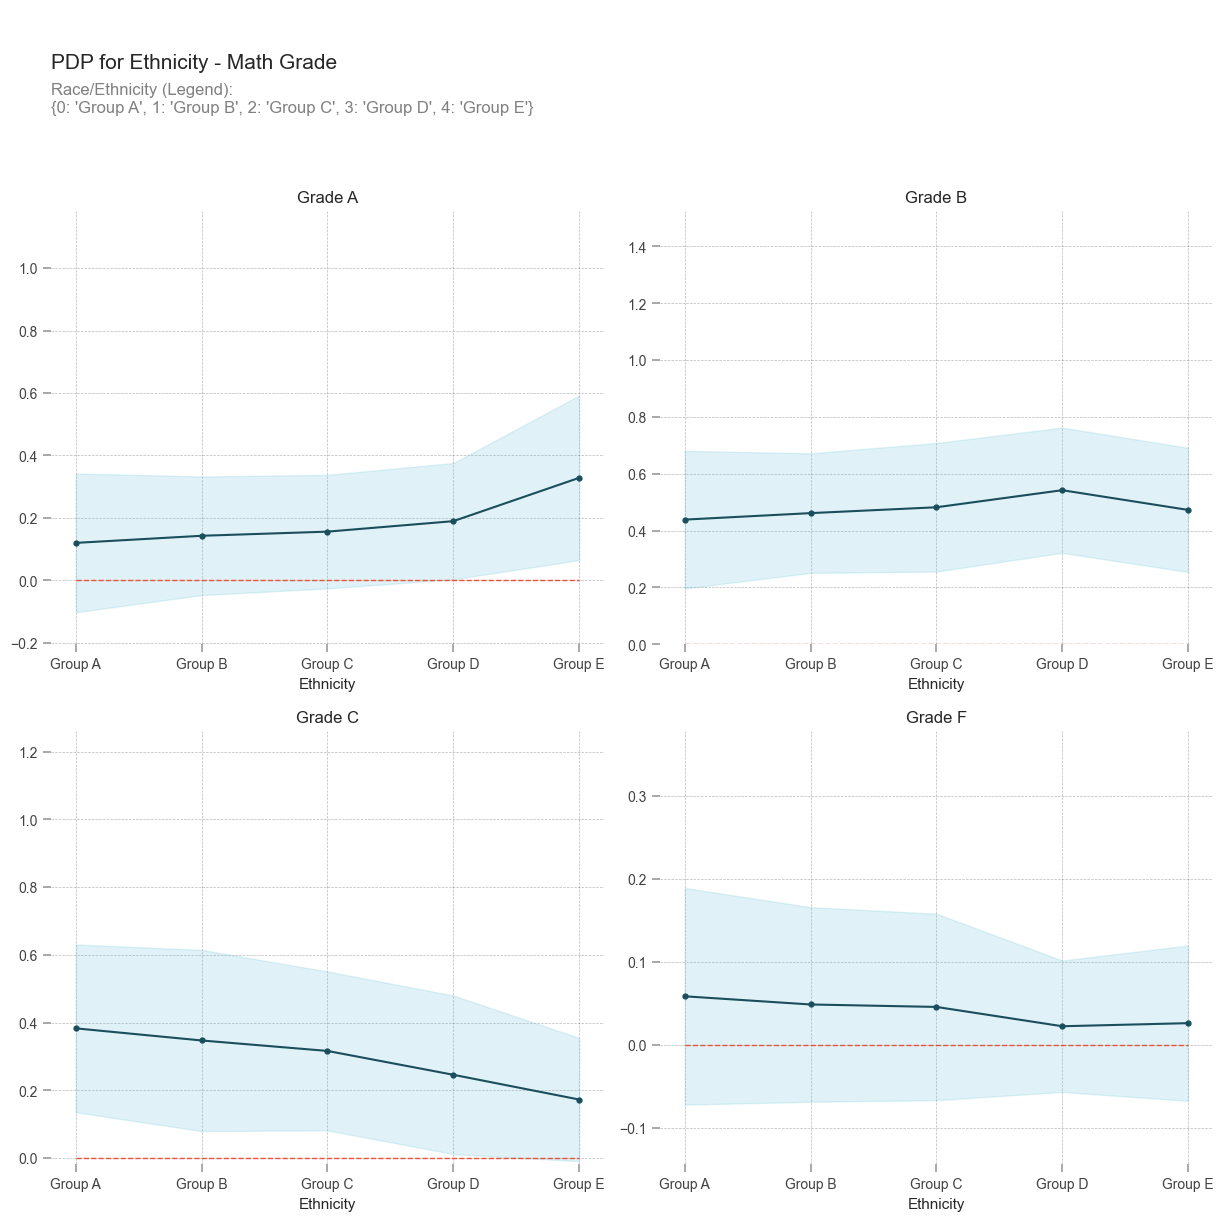

In [46]:
pdp_race = pdp.pdp_isolate(model=math_model,
                          dataset=df,
                          model_features=feature_cols,
                          feature='race_le')
ethnicity_xtick_labels = ['Group A', 'Group B', 'Group C',
                          'Group D', 'Group E']
plot_params = {
    # plot title and subtitle
    'title': 'PDP for Ethnicity - Math Grade',
    'subtitle': 'Race/Ethnicity (Legend): \n%s' % (race_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_race, feature_name='Race/Ethnicity', 
                         center=False, x_quantile=False, ncols=2, plot_lines=False, frac_to_plot=100,
                         plot_params=plot_params)
axes['pdp_ax'][0].set_xlabel('Ethnicity')
axes['pdp_ax'][1].set_xlabel('Ethnicity')
axes['pdp_ax'][2].set_xlabel('Ethnicity')
axes['pdp_ax'][3].set_xlabel('Ethnicity')
axes['pdp_ax'][0].set_title('Grade A')
axes['pdp_ax'][1].set_title('Grade B')
axes['pdp_ax'][2].set_title('Grade C')
axes['pdp_ax'][3].set_title('Grade F')
axes['pdp_ax'][0].set_xticks(race_codes)
axes['pdp_ax'][1].set_xticks(race_codes)
axes['pdp_ax'][2].set_xticks(race_codes)
axes['pdp_ax'][3].set_xticks(race_codes)
axes['pdp_ax'][0].set_xticklabels(ethnicity_xtick_labels)
axes['pdp_ax'][1].set_xticklabels(ethnicity_xtick_labels)
axes['pdp_ax'][2].set_xticklabels(ethnicity_xtick_labels)
axes['pdp_ax'][3].set_xticklabels(ethnicity_xtick_labels)

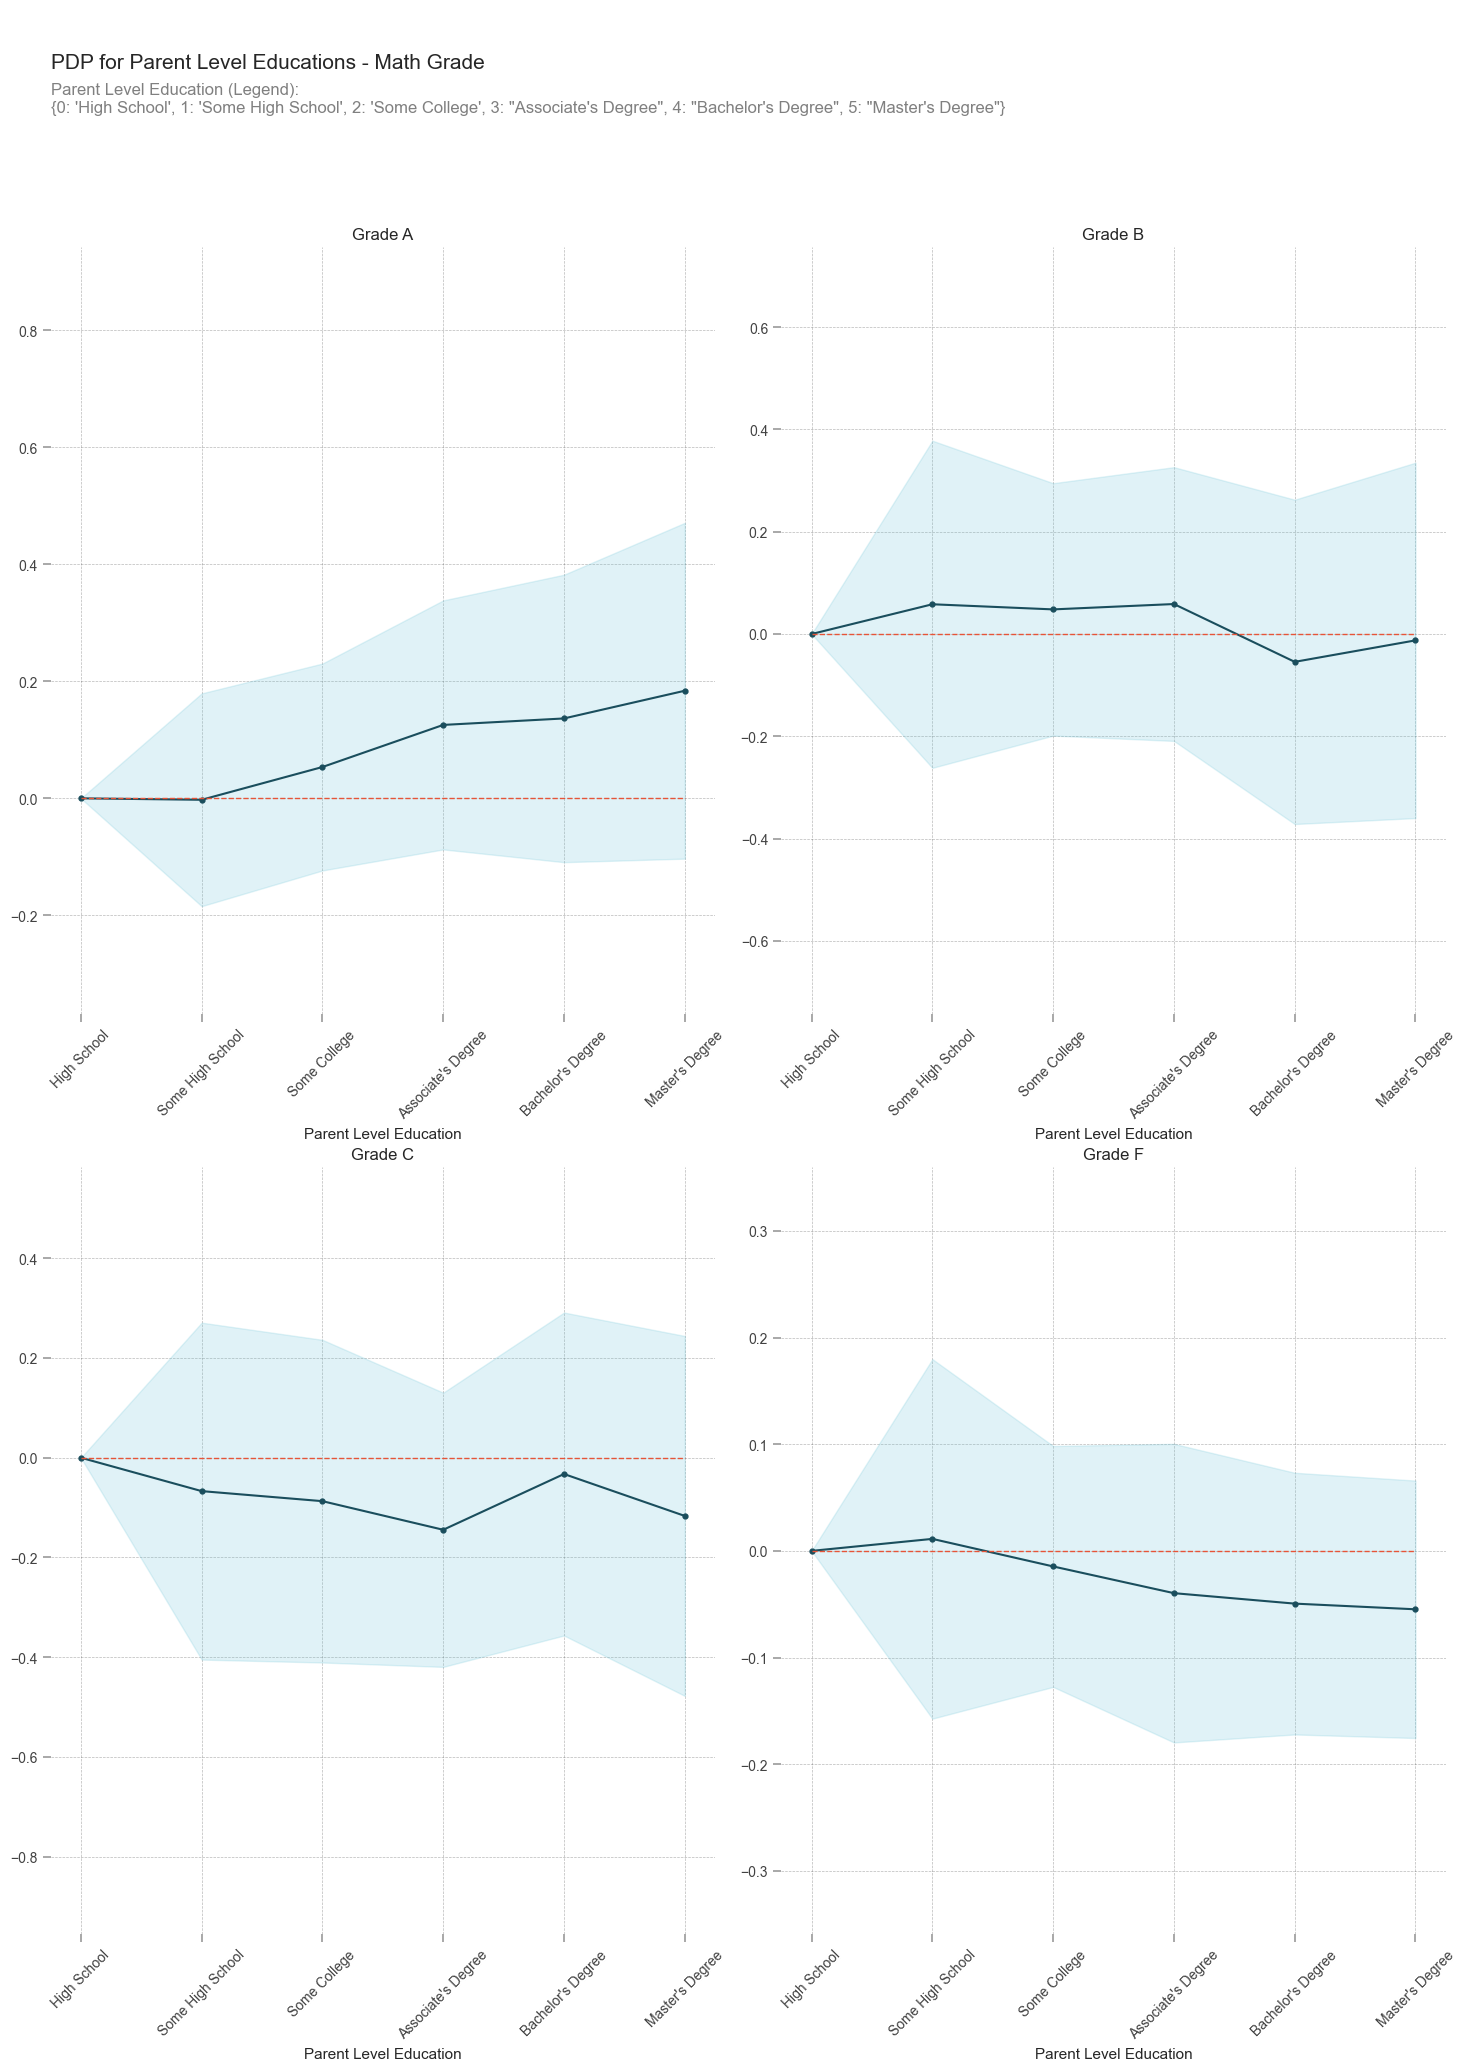

In [47]:


pdp_race = pdp.pdp_isolate(model=math_model,
                          dataset=df,
                          model_features=feature_cols,
                          feature='parent_le')
ple_xticklabels = ['High School',
                   'Some High School',
                   'Some College',
                   "Associate\'s Degree",
                   "Bachelor\'s Degree",
                   "Master\'s Degree"]
plot_params = {
    # plot title and subtitle
    'title': 'PDP for Parent Level Educations - Math Grade',
    'subtitle': 'Parent Level Education (Legend): \n%s' % (parent_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_race, feature_name='Parent Level Education', 
                         center=True, x_quantile=False, ncols=2, plot_lines=False, frac_to_plot=100,
                         plot_params=plot_params, figsize=(18, 25))
axes['pdp_ax'][0].set_xlabel('Parent Level Education')
axes['pdp_ax'][1].set_xlabel('Parent Level Education')
axes['pdp_ax'][2].set_xlabel('Parent Level Education')
axes['pdp_ax'][3].set_xlabel('Parent Level Education')
axes['pdp_ax'][0].set_title('Grade A')
axes['pdp_ax'][1].set_title('Grade B')
axes['pdp_ax'][2].set_title('Grade C')
axes['pdp_ax'][3].set_title('Grade F')
axes['pdp_ax'][0].set_xticks(parent_codes)
axes['pdp_ax'][1].set_xticks(parent_codes)
axes['pdp_ax'][2].set_xticks(parent_codes)
axes['pdp_ax'][3].set_xticks(parent_codes)
axes['pdp_ax'][0].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][1].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][2].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][3].set_xticklabels(ple_xticklabels)
for tick in axes['pdp_ax'][0].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][1].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][2].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][3].get_xticklabels():
    tick.set_rotation(45)

- 위에서 부모의 교육 수준에 대한 부분 의존도는 각 학년 A, B, C, F에 대해 개별적으로 표시됩니다.  
- 이 분류모델에 대한 학습된 수학 모델 함수는 0에서 1 사이의 확률 측정값이기 때문에 부분 의존성 함수의 값 범위는 0에서 1 사이입니다.  
- 이제 몇 가지 성적을 확대하여 부모의 교육 수준이 학생의 성적에 미치는 영향을 분석해 보겠습니다.

![Alt text](image-5.png)

- 위에서 수학 A등급에 대한 PDP를 확대했습니다.  
- 3.1.1절에서 부모가 고졸 학력일 때보다 석사 학력일 때 수학에서 A등급을 받는 학생의 비율이 더 높다는 것을 확인했습니다(그림 3.4 참조). - - 랜덤 포레스트 모델은 이 패턴을 학습했을까요? 그림 3.11에서 부모의 교육 수준이 높아질수록 A 등급을 받는 데 미치는 영향이 증가한다는 것을 알 수 있습니다.  
- 고등학교 교육을 받은 부모의 경우 수학 A등급 예측에 미치는 영향은 0에 가까울 정도로 미미합니다. 이는 고등학교 교육을 받았다고 해서 모델에 아무런 변화가 없으며, 부모 교육 수준 이외의 다른 특징이 A등급을 예측할 때 작용한다는 것을 의미합니다.  
- 그러나 부모가 석사 학위를 받은 경우 약 +0.2의 높은 양의 영향을 볼 수 있습니다. 즉, 평균적으로 석사 학위가 있으면 학생이 A 등급을 받을 확률이 약 0.2 정도 높아진다는 의미입니다.

![Alt text](image-6.png)

- 학 F 성적의 PDP를 확대한 결과, 부모의 학력이 높을수록 F 성적 예측에 부정적인 영향을 미치는 하향 추세를 확인할 수 있습니다.  
- 부모가 석사 학위를 가진 학생은 대략 -0.05의 부정적인 영향을 미치는 것을 알 수 있습니다.  
- 즉, 부모가 석사 학위를 가지고 있으면 학생이 F등급을 받을 가능성이 낮아지고, 따라서 학생이 A등급을 받을 가능성이 높아진다는 것을 의미합니다.  
- 이러한 인사이트는 매우 훌륭하며 기능 중요도만으로는 불가능했을 것입니다.  
- 이 시스템의 최종 사용자(즉, 교육감)는 자신이 사용하는 모델에 대해 더 많은 신뢰를 갖게 될 것입니다.

- 연습 삼아 수학 학년과 학부모 교육 수준에 대한 PDP 코드를 다른 과목 영역인 읽기와 쓰기로 확장하는 것이 좋습니다.  
- 3.1.1 섹션(그림 3.4 참조)에서 관찰된 패턴이 랜덤 포레스트 모델에 의해 학습되었는지 확인할 수 있습니다.  
- 코드를 다른 기능으로 확장할 수도 있습니다. 연습으로, 학생의 인종 또는 민족 중 두 번째로 중요한 특징을 선택하고 해당 특징에 대한 PDP를 생성해 보세요.

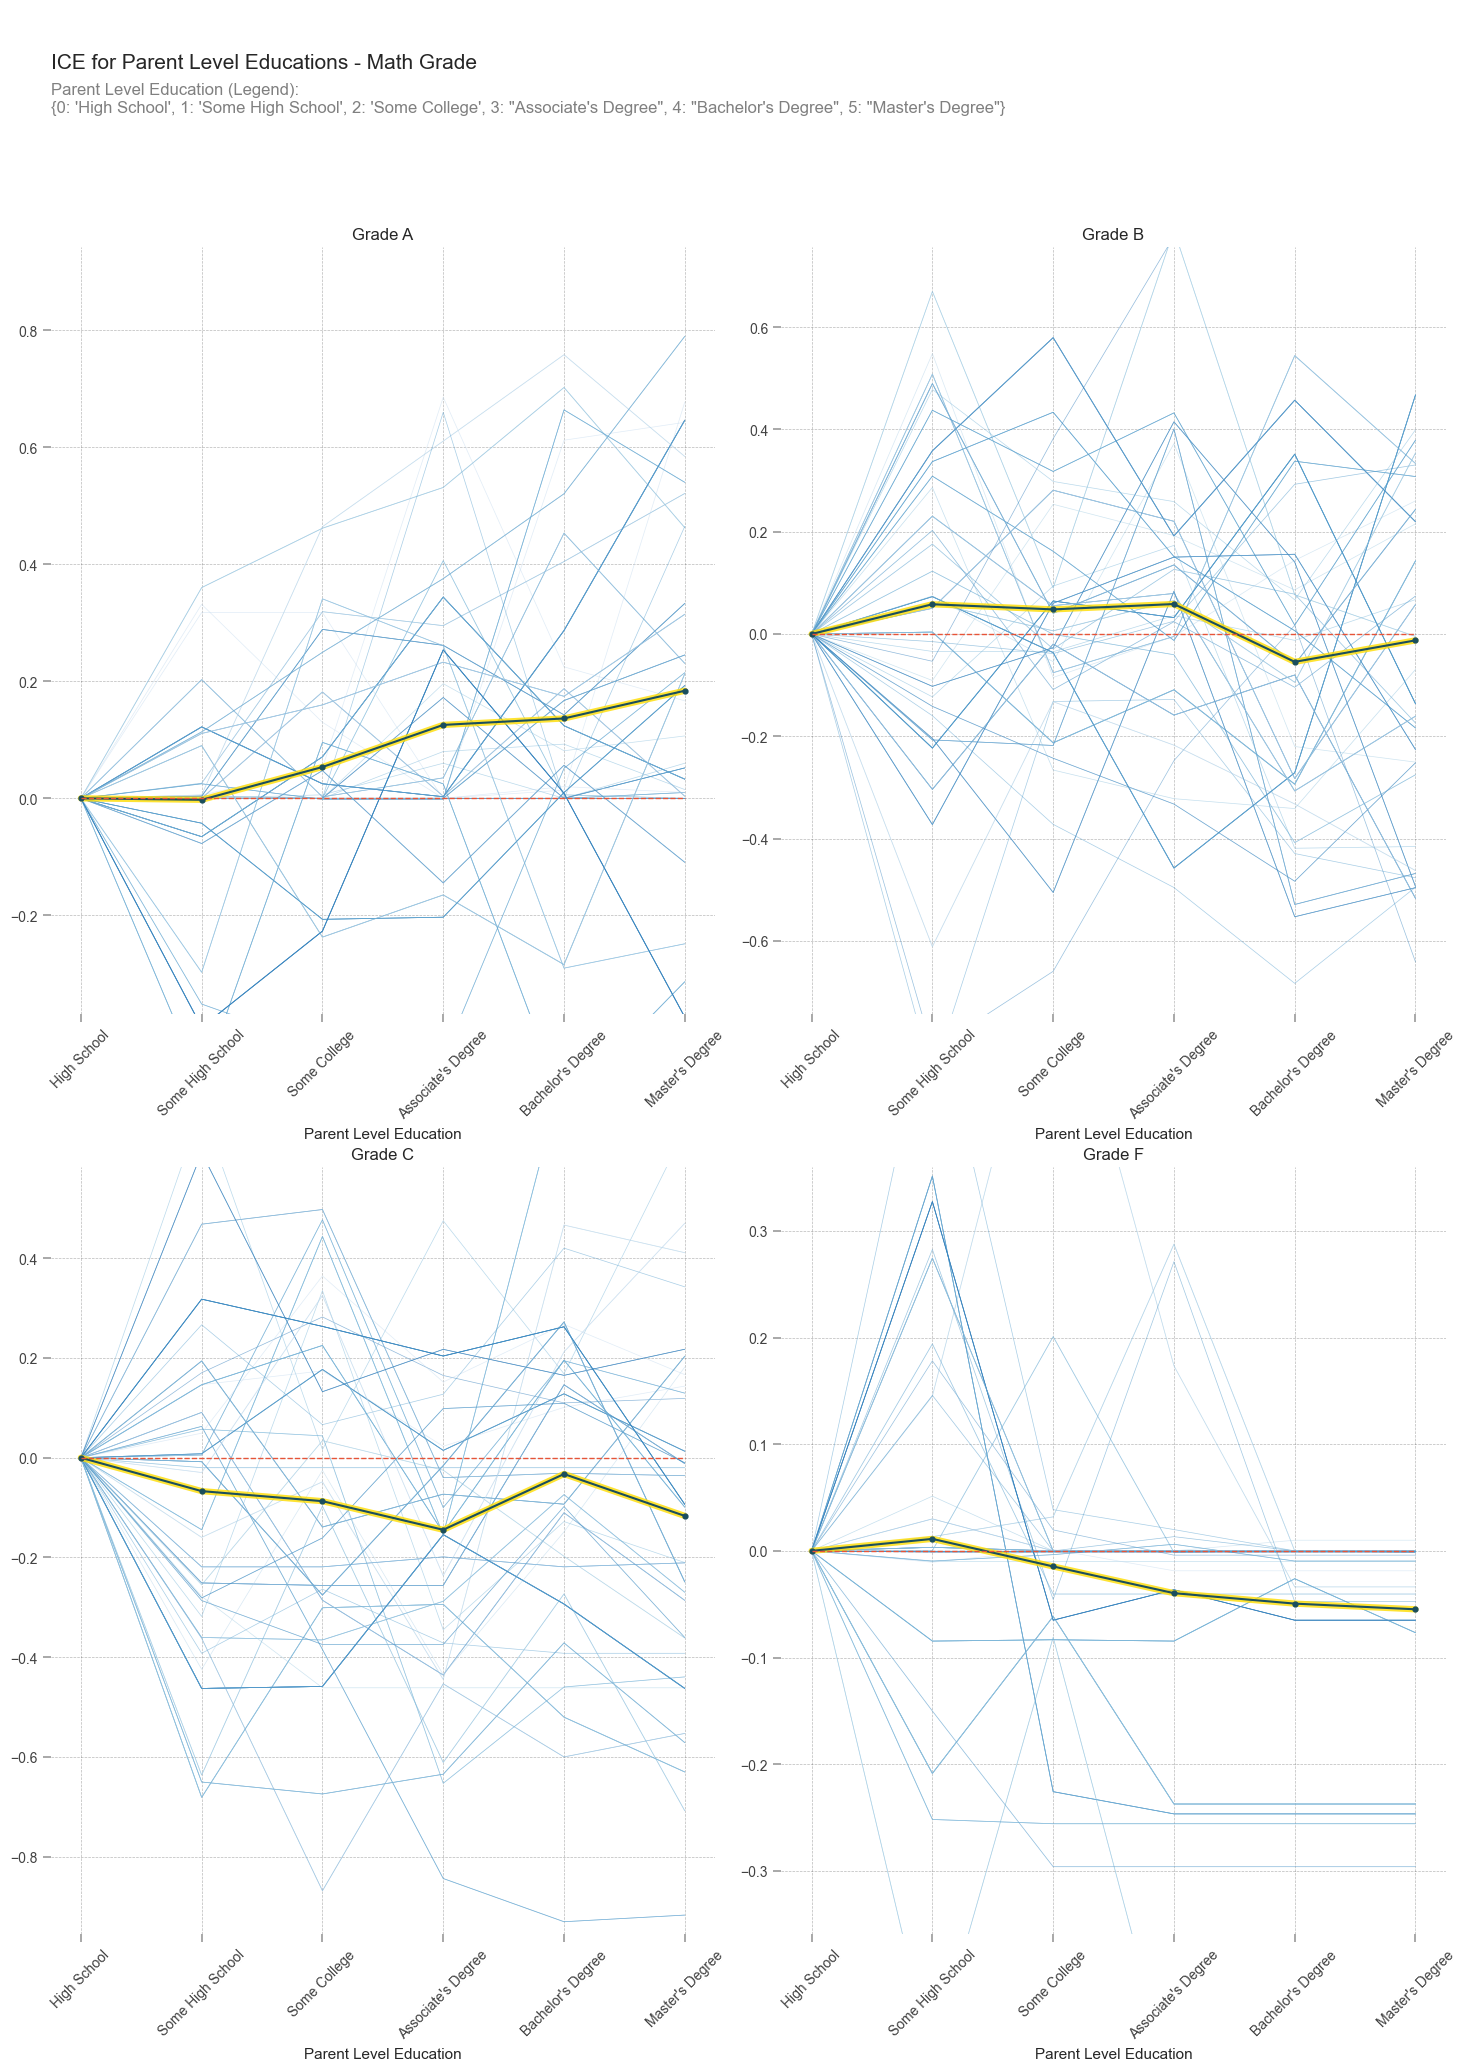

In [48]:
pdp_race = pdp.pdp_isolate(model=math_model,
                          dataset=df,
                          model_features=feature_cols,
                          feature='parent_le')
ple_xticklabels = ['High School',
                   'Some High School',
                   'Some College',
                   "Associate\'s Degree",
                   "Bachelor\'s Degree",
                   "Master\'s Degree"]
plot_params = {
    # plot title and subtitle
    'title': 'ICE for Parent Level Educations - Math Grade',
    'subtitle': 'Parent Level Education (Legend): \n%s' % (parent_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_race, feature_name='Parent Level Education', 
                         center=True, x_quantile=False, ncols=2, plot_lines=True, frac_to_plot=100,
                         plot_params=plot_params, figsize=(18, 25))
axes['pdp_ax'][0].set_xlabel('Parent Level Education')
axes['pdp_ax'][1].set_xlabel('Parent Level Education')
axes['pdp_ax'][2].set_xlabel('Parent Level Education')
axes['pdp_ax'][3].set_xlabel('Parent Level Education')
axes['pdp_ax'][0].set_title('Grade A')
axes['pdp_ax'][1].set_title('Grade B')
axes['pdp_ax'][2].set_title('Grade C')
axes['pdp_ax'][3].set_title('Grade F')
axes['pdp_ax'][0].set_xticks(parent_codes)
axes['pdp_ax'][1].set_xticks(parent_codes)
axes['pdp_ax'][2].set_xticks(parent_codes)
axes['pdp_ax'][3].set_xticks(parent_codes)
axes['pdp_ax'][0].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][1].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][2].set_xticklabels(ple_xticklabels)
axes['pdp_ax'][3].set_xticklabels(ple_xticklabels)
for tick in axes['pdp_ax'][0].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][1].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][2].get_xticklabels():
    tick.set_rotation(45)
for tick in axes['pdp_ax'][3].get_xticklabels():
    tick.set_rotation(45)

### Feature interactions

PDP를 확장하여 특징 상호작용을 이해할 수 있습니다. 방정식 3.4.1로 돌아가서 이제 집합 S에서 두 개의 특징을 살펴보고 나머지는 한계화하겠습니다.   
수학에서 A, B, C, F 성적을 예측할 때 가장 중요한 두 가지 특징인 부모 교육 수준과 학생 민족성 간의 상호 작용을 살펴보겠습니다.  
다음 코드 스니펫에 표시된 것처럼 PDPBox를 사용하여 두 피처의 상호 작용을 쉽게 시각화할 수 있습니다:

![Alt text](image-7.png)

이 코드에 의해 생성된 플롯은 그림 3.13에 나와 있습니다. 각 학년에 대해 하나씩 4개의 플롯이 생성됩니다. 기능 상호 작용은 6개의 부모 교육 수준 기능이 Y축에 있고 5개의 민족성 기능이 X축에 있는 2D 그리드에서 시각화됩니다. 이 플롯을 자세히 분석하고 설명하기 위해 A 학년을 확대하겠습니다.

In [49]:
pdp_race_parent = pdp.pdp_interact(model=math_model,
                                   dataset=df,
                                   model_features=feature_cols,
                                   features=['race_le', 'parent_le'])
plot_params = {
    # plot title and subtitle
    'title': 'PDP Interaction - Math Grade',
    'subtitle': 'Race/Ethnicity (Legend): \n%s\nParent Level of Education (Legend): \n%s' % (race_title, parent_title),
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}
fig, axes = pdp.pdp_interact_plot(pdp_race_parent, ['Race/Ethnicity', 'Parent Level of Education'],
                                  plot_type='grid', plot_pdp=True, plot_params=plot_params)
axes['pdp_inter_ax'][0]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade A)')
axes['pdp_inter_ax'][1]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade B)')
axes['pdp_inter_ax'][2]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade C)')
axes['pdp_inter_ax'][3]['_pdp_x_ax'].set_xlabel('Race/Ethnicity (Grade F)')
axes['pdp_inter_ax'][0]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][0]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][0]['_pdp_y_ax'].grid(False)
axes['pdp_inter_ax'][1]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][1]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][1]['_pdp_y_ax'].grid(False)
axes['pdp_inter_ax'][2]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][2]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][2]['_pdp_y_ax'].grid(False)
axes['pdp_inter_ax'][3]['_pdp_inter_ax'].grid(False)
axes['pdp_inter_ax'][3]['_pdp_x_ax'].grid(False)
axes['pdp_inter_ax'][3]['_pdp_y_ax'].grid(False)

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1500x1700 with 17 Axes>

![Alt text](image-8.png)

- 아래 그림은 수학 성적 A에 대한 기능 상호 작용도를 보여줍니다.  
- 부모의 교육 수준은 y축에, 학생의 익명화된 인종은 x축에 있습니다.  
- Y축의 아래쪽에서 위쪽으로 갈수록 부모의 교육 수준은 고등학교에서 석사 학위까지 증가합니다. 고등학교 학력은 0으로 표시되고 석사 학위는 5로 표시됩니다.  
- x축은 A, B, C, D, E의 다섯 가지 인종 그룹을 나타냅니다. 인종 그룹 A는 0, 그룹 B는 1, 그룹 C는 2 등의 값으로 표시됩니다. 각 셀의 숫자는 주어진 부모의 교육 수준 및 학생의 민족성이 A 등급을 받는 데 미치는 영향을 나타냅니다.

예를 들어, 가장 아래쪽 행과 가장 왼쪽 열의 셀은 인종 그룹 A에 속하고 고등학교 학력을 가진 부모를 둔 학생이 A 등급을 받는 데 미치는 평균 영향을 나타냅니다. 그리드의 각 셀에 있는 숫자 값에 유의하세요. 숫자가 낮을수록 영향력이 낮고, 숫자가 높을수록 A 등급 예측에 미치는 영향력이 높음을 나타냅니다.

![Alt text](image-9.png)

이제 그림 3.15에서 강조 표시된 그리드의 가장 왼쪽 열인 인종 그룹 A에 집중해 보겠습니다. 부모의 교육 수준이 증가함에 따라 A등급 예측에 미치는 영향도 증가하는 것을 볼 수 있습니다. 이는 부모의 교육 수준이 인종보다 성적에 더 큰 영향을 미친다는 것을 보여주기 때문에 의미가 있습니다. 이는 그림 3.9에 표시된 특징 중요도 그래프에서도 확인할 수 있습니다. 따라서 이 모델은 이 패턴을 잘 학습했습니다.

![Alt text](image-10.png)

- 하지만 아래 그림에서 강조 표시된 세 번째 열인 인종 그룹 C에서는 어떤 일이 일어나고 있을까요?  
- 부모가 고졸 학위인 학생은 부모가 석사 학위인 학생보다 A등급 예측에 더 높은 긍정적인 영향을 미치는 것처럼 보입니다(강조 표시된 열의 가장 아래쪽 셀과 가장 위쪽 셀을 비교). 
- 그리고 부모가 준학사 학위를 가진 학생이 다른 교육 수준보다 A 등급을 예측하는 데 가장 높은 긍정적 영향을 미치는 것으로 보입니다(강조 표시된 열의 맨 위 세 번째 셀 참조).  
- 이는 다음 문제 중 하나 이상을 노출할 수 있으므로 약간 우려됩니다:

- 부모의 교육 수준이 민족 특성과 상관 관계가 있을 수 있으며, 따라서 신뢰할 수 없는 특성 상호 작용 플롯을 초래할 수 있습니다.
- 데이터 집합이 모집단, 특히 민족성 그룹 C를 제대로 나타내지 않습니다. 이를 샘플링 편향이라고 합니다.
- 이 모델은 편향되어 있으며 부모의 교육 수준과 민족 간의 상호 작용을 제대로 학습하지 못했습니다.
- 이 데이터 집합은 사회의 체계적인 편견을 노출합니다.

![Alt text](image-11.png)

- 첫 번째 문제는 PDP의 한계를 드러내는 것으로, 이 한계에 대해서는 다음 단락에서 설명하겠습니다.  
- 두 번째 문제는 모집단을 대표할 수 있는 더 많은 데이터를 수집하면 해결할 수 있습니다. 8장에서 다른 형태의 편향과 이를 완화하는 방법에 대해 배우게 됩니다.  
- 세 번째 문제는 더 많은 기능을 추가하거나 더 나은 복잡한 모델을 학습시킴으로써 해결할 수 있습니다.  
- 마지막 문제는 해결하기가 훨씬 더 어렵고 더 나은 정책과 법률이 필요하지만 이 책에서는 다루지 않습니다.

- 첫 번째 문제가 존재하는지 확인하기 위해 부모 교육 수준과 민족 간의 상관 관계를 살펴봅시다. 2장에서 상관관계 행렬을 계산하고 시각화하는 방법을 살펴봤습니다. 피어슨 상관 계수를 사용하여 해당 문제에 대한 특징 간의 상관 관계를 정량화했습니다.  

이 계수는 숫자 특징에만 사용할 수 있고 범주형 특징에는 사용할 수 없습니다.  
이 예에서는 범주형 특징을 다루고 있으므로 다른 메트릭을 사용해야 합니다. 두 범주형 변수 간의 연관성을 측정하기 때문에 크레이머의 V 통계를 사용할 수 있습니다.  
이 통계는 0에서 1 사이일 수 있으며, 0은 상관관계/연관성이 없음을 나타내고 1은 상관관계/연관성이 최대임을 나타냅니다.  
다음 도우미 함수를 사용하여 이 통계를 계산할 수 있습니다:

![Alt text](image-12.png)

In [50]:
df_gpA = df[df['race/ethnicity'] == 'group A'].reset_index()
df_gpC = df[df['race/ethnicity'] == 'group C'].reset_index()

In [51]:
import scipy.stats as ss
def cramers_corrected_stat(confusion_matrix):
    """ Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [52]:
def get_ple_pcs(df):
    levels = ['high school', 'some high school', 'some college', 'associate\'s degree', 'bachelor\'s degree',
              'master\'s degree']
    df_ple = df.groupby('parental level of education').agg({'lunch': 'count'}).reset_index()
    pcs = []
    for level in levels:
        pc = df_ple[df_ple['parental level of education'] == level]['lunch'].values[0] / len(df) * 100
        pcs.append(pc)
    return levels, pcs
levels, pcs = get_ple_pcs(df)
_, pcs_gpA = get_ple_pcs(df_gpA)
_, pcs_gpC = get_ple_pcs(df_gpC)

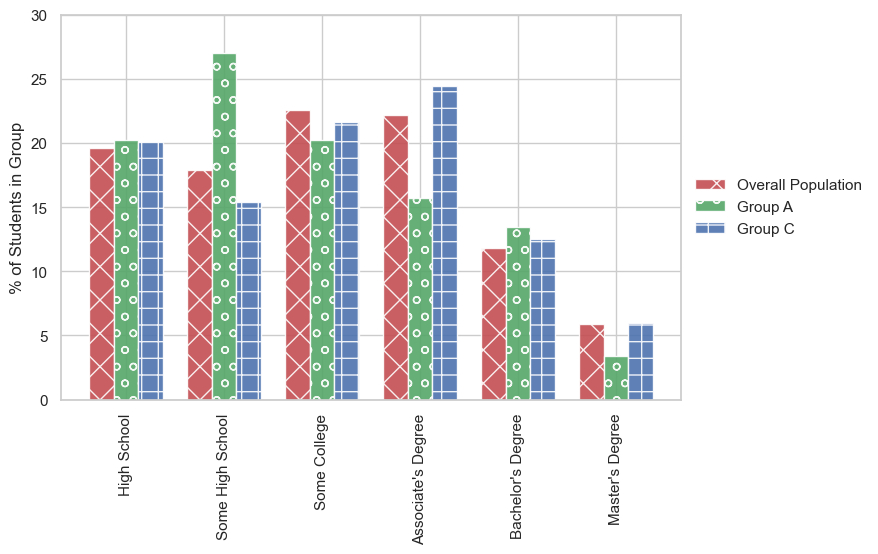

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))
index = np.arange(len(levels))
capitalized_labels = []
for label in levels:
    words = label.split(' ')
    capitalized_label = ' '.join([w.capitalize() for w in words])
    capitalized_labels.append(capitalized_label)
bar_width = 0.25
opacity = 0.9
error_config = {'ecolor': '0.3'}
ax.bar(index, pcs, bar_width,
       alpha=opacity, color='r',
       label='Overall Population',
       hatch='x')
ax.bar(index + bar_width, pcs_gpA, bar_width,
       alpha=opacity, color='g',
       label='Group A',
       hatch='o')
ax.bar(index + bar_width * 2, pcs_gpC, bar_width,
       alpha=opacity, color='b',
       label='Group C',
       hatch='+')   
ax.set_xlabel('')
ax.set_ylabel('% of Students in Group')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(capitalized_labels)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True);
ax.set_ylim([0, 30]);

In [54]:
confusion_matrix = pd.crosstab(df['parental level of education'], 
                               df['race/ethnicity'])
cramers_corrected_stat(confusion_matrix)

0.04867387848351325

이 코드 줄을 실행하면 부모 교육 수준과 인종 간의 상관 관계 또는 연관성이 0.0486임을 알 수 있습니다.  
이는 매우 낮은 수치이므로 피처 상호 작용 플롯 또는 PDP를 신뢰할 수 없는 문제를 배제할 수 있습니다.  
그림 3.5에서 그룹 C에 속한 학생이 그룹 A에 속한 학생보다 성적이 더 좋은 것을 볼 수 있는데, 이는 모델이 이러한 패턴을 학습했기 때문일 수 있습니다.  
그림 3.14, 3.15, 3.16의 맨 위 범례를 보면 이를 확인할 수 있습니다.  
학생이 C그룹에 속할 경우 A등급 예측에 +0.153의 양의 영향을 미치며, 이는 A그룹에 속할 때의 영향력인 +0.125보다 더 큽니다.  
이제 그림 3.17에 표시된 민족성 그룹 A와 C의 부모 교육 수준 분포의 차이를 살펴보겠습니다.

그림 3.17에서 민족성 그룹 A에 속한 학생의 부모는 전체 인구와 그룹 C에 속한 학생보다 고등학교 또는 일부 고등학교 교육을 받았을 가능성이 훨씬 더 높다는 것을 알 수 있습니다. 또한 그룹 C는 부모가 준학사 학위를 가진 학생의 비율이 전체 인구와 그룹 A보다 높습니다. 분포의 차이가 매우 두드러집니다. 데이터 집합이 전체 인구와 각 인종 그룹을 정확하게 나타내는지 확실하지 않습니다. 데이터 과학자로서 이해관계자(이 예에서는 교육감)에게 이 문제를 강조하고 데이터 집합이 합법적이며 샘플링 편향이 없는지 확인하는 것이 중요합니다. 이 섹션에서 중요한 점은 해석 가능성 기법, 특히 PDP와 피처 상호 작용은 모델이 프로덕션에 배포되기 전에 모델 또는 데이터의 잠재적 문제를 드러내는 데 훌륭한 도구라는 것입니다. 이 섹션의 인사이트 중 어떤 것도 피처의 중요성만 보고는 얻을 수 없었을 것입니다. 연습 삼아 그라데이션 부스팅 트리와 같은 다른 블랙박스 모델에 PDPBox 패키지를 사용해 보시기 바랍니다.

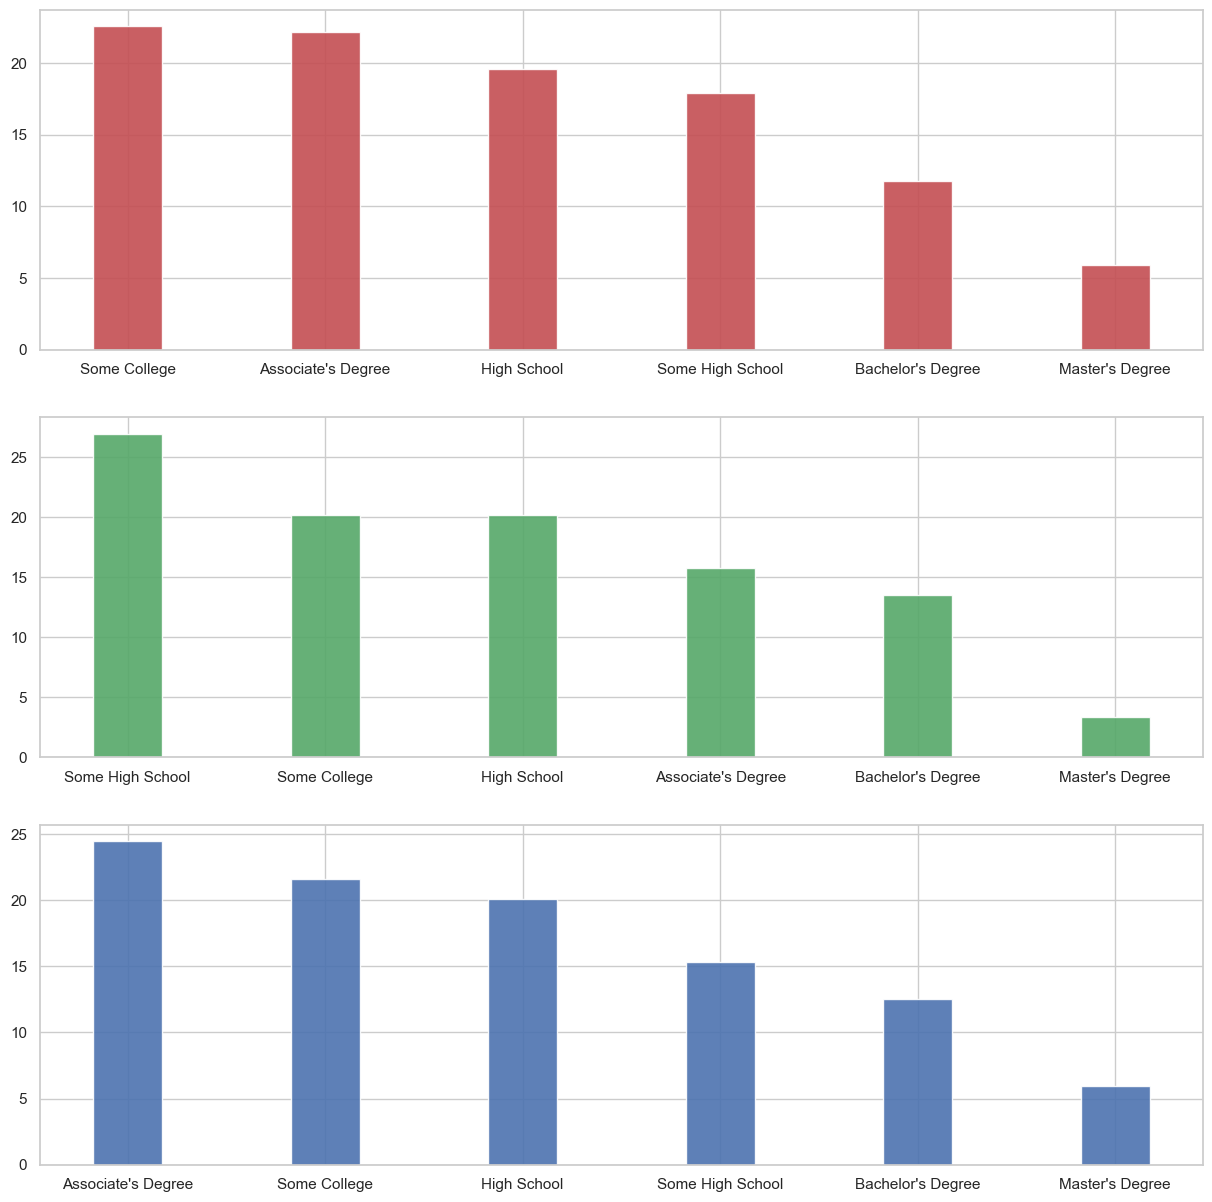

In [56]:
f, ax = plt.subplots(3, 1, figsize=(15, 15))
plot_vc_bar_charts(df, 'parental level of education', ax[0], 'r')
plot_vc_bar_charts(df_gpA, 'parental level of education', ax[1], 'g')
plot_vc_bar_charts(df_gpC, 'parental level of education', ax[2], 'b')